### <font color=orange> Importing Libraries </font>

In [1]:
import numpy as np
import random

#   Plotting
import seaborn as sns
import matplotlib.pyplot as plt


#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model

import tensorflow as tf
import tensorflow_addons as tfa

#   count each class samples
from collections import Counter

#   callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

#   evaluate precison recall and f1-score of each class of model
from sklearn.metrics import classification_report
#   Show performance of a classification model
from sklearn.metrics import confusion_matrix

#   Different layers
from keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax

# split dataset to train, validation and test set
from sklearn.model_selection import train_test_split

#   callbacks
from keras import callbacks

#   SMOTETomek from imblance library
from imblearn.combine import SMOTETomek

#   Optimizer
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import roc_curve, auc
from itertools import cycle

# State of the art models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.densenet import DenseNet169 

### <font color=orange> Define directory of dataset & Classes names </font>

In [2]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "/kaggle/input/alz-dataset/dataset"

##  Name of classes 
CLASSES = ['Mild-Demented',
           'Moderate-Demented',
           'Non-Demented',
           'VeryMild-Demented']

### <font color=orange> Load Images, Rescale Images, and seperate from data generator & Label One Hot encoding </font>

In [3]:
X, y = [], []
height, width = 128, 128

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory(WORKING_DIRECTORY, target_size=(height, width),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6400 images belonging to 4 classes.


In [4]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (6400, 128, 128, 3)
Labels shape :	 (6400, 4)


In [5]:
#   Number of samples in classes 
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 896), (1, 64), (2, 3200), (3, 2240)]
Classes Names according to index:	 {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


### <font color=orange> Show some random samples from the origional dataset </font>

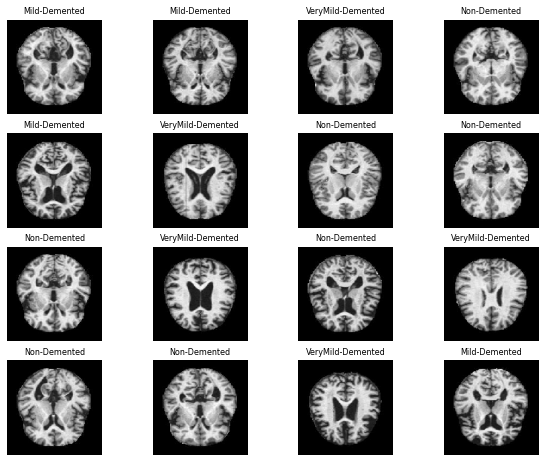

In [6]:
#   show some samples from the dataset randomly
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

### <font color=orange> Apply SMOTETomek Algorithm to balance the dataset </font>

<p><font color=red> Don't run this code if (height, width) > 128, incase this will exceed the memory size allocated to you. </font> <br>

Instead of that you can change the Height and Width of these to 128 to both, then it may work properly here.</p>

#### This code will take approx. 10 minutes to complete

In [7]:
#   reshaping the images to 1D
X = X.reshape(-1, width * height * 3)

#   Oversampling method to remove imbalance class problem
X, y = SMOTETomek().fit_resample(X, y)

#   reshape images to images size of 208, 176, 3
X = X.reshape(-1, width, height, 3)

samples_after = len(X)
print("Number of samples after SMOTETomek :\t", sorted(Counter(np.argmax(y, axis=1)).items()))

Number of samples after SMOTETomek :	 [(0, 3200), (1, 3200), (2, 3200), (3, 3200)]


### <font color=orange> Show some random samples from the Generated dataset </font>

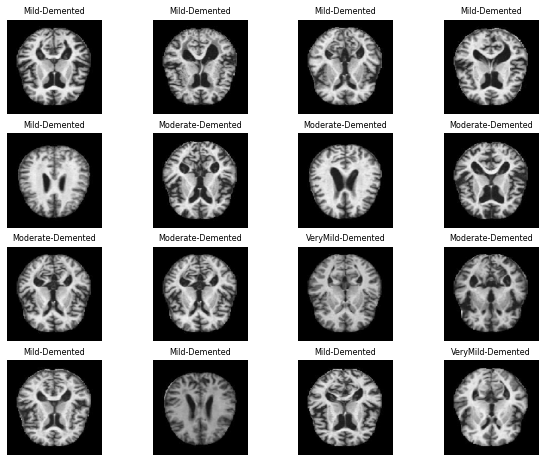

In [8]:
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(samples_before, samples_after - 1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

### <font color=orange> Splitting dataset for Training, Validation & Testing </font>

In [9]:
#   20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

#   20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)

# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 2021), (1, 2040), (2, 2055), (3, 2076)]
Validation	 [(0, 669), (1, 644), (2, 629), (3, 618)]
Test      	 [(0, 510), (1, 516), (2, 516), (3, 506)]


In [10]:
#   to free memeory we don't need this one as we split our data
del X, y

### <font color=orange> Model Architecture </font>
<p>Ignore warnings if printed in output</p>

In [11]:
# Densenet169model = DenseNet169(weights="imagenet", include_top=False,
#     input_tensor=Input(shape=(width, height, 3)))

# outputs = Densenet169model.output
# outputs = Flatten(name="flatten")(outputs)
# outputs = Dropout(0.4)(outputs)
# outputs = Dense(4, activation="softmax")(outputs)

# model = Model(inputs=VGGmodel.input, outputs=outputs)

# for layer in VGGmodel.layers:
#     layer.trainable = False
    
model = DenseNet169(input_shape=(width,height,3), weights='imagenet', include_top=False)
for layer in model.layers:
    layer.trainable = False
outputs = Flatten()(model.output)
outputs = Dropout(0.4)(outputs)
outputs = Dense(4, activation="softmax")(outputs)
model = Model(inputs=model.input, outputs=outputs)





51888128/51877672 [==============================] - 0s 0us/step


### <font color=orange> Compiling the Model </font>

In [12]:
### Model Compilation
model.compile(
    optimizer='adam', 
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'), 
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'), 
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])


### <font color=orange> Defining CALLBACKS to reduce Learning Rate </font>

In [13]:
# callbacks used in model to perform well
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=2)

CALLBACKS = [rop_callback]

### <font color=orange> Training of the Model </font>

In [23]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

#   defining batch size
batch_size = 20

history = model.fit(valAug.flow(X_train, y_train, batch_size=batch_size, shuffle = True),
steps_per_epoch=len(X_train) // batch_size,
validation_data=valAug.flow(x_val, y_val, batch_size=batch_size, shuffle = True),
validation_steps=len(x_test) // batch_size,
epochs= 40,
batch_size=batch_size,
callbacks = CALLBACKS
                
)

Epoch 1/40
409/409 [==============================] - 17s 41ms/step - loss: 0.4063 - acc: 0.8751 - auc: 0.9761 - f1_score: 0.8754 - precision: 0.8774 - recall: 0.8729 - val_loss: 0.2902 - val_acc: 0.9044 - val_auc: 0.9857 - val_f1_score: 0.9018 - val_precision: 0.9067 - val_recall: 0.9000
Epoch 2/40
409/409 [==============================] - 16s 39ms/step - loss: 0.4085 - acc: 0.8775 - auc: 0.9751 - f1_score: 0.8779 - precision: 0.8807 - recall: 0.8752 - val_loss: 0.2638 - val_acc: 0.9098 - val_auc: 0.9876 - val_f1_score: 0.9080 - val_precision: 0.9126 - val_recall: 0.9059
Epoch 3/40
409/409 [==============================] - 17s 41ms/step - loss: 0.4080 - acc: 0.8780 - auc: 0.9756 - f1_score: 0.8783 - precision: 0.8808 - recall: 0.8765 - val_loss: 0.2887 - val_acc: 0.9064 - val_auc: 0.9860 - val_f1_score: 0.9038 - val_precision: 0.9096 - val_recall: 0.9029
Epoch 4/40
409/409 [==============================] - 16s 40ms/step - loss: 0.3764 - acc: 0.8853 - auc: 0.9783 - f1_score: 0.8857 

### <font color=orange> Evaluation of Model with the Test data </font>

In [15]:
### Evaluate Model
test_scores = model.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

64/64 [==============================] - 6s 37ms/step - loss: 0.3193 - acc: 0.9004 - auc: 0.9817 - f1_score: 0.8999 - precision: 0.9038 - recall: 0.8989


Testing Loss : 		 0.319260
Testing Accuracy : 	 90.039062 %
Testing AC : 		 98.170120 %
Testing F1-Score : 	 89.994150 %
Testing Precision : 	 90.378004 %
Testing Recall : 	 89.892578 %


### <font color=orange> Model Training graphs </font>
- Accuracy
- Loss
- AUC
- Precision
- Recall
- F1-Score

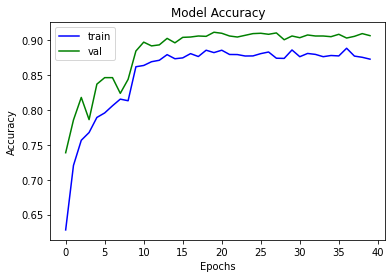

In [16]:
plt.plot(history.history['acc'], 'b')
plt.plot(history.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

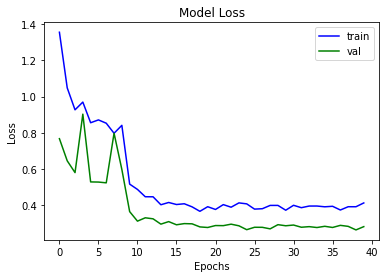

In [17]:
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

### <font color=orange> Test set Evaluation </font>
- Classification Report
- Confusion Matrix
- ROC Curve
- Extension ROC Multiclass

In [18]:
pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))


                   precision    recall  f1-score   support

    Mild-Demented       0.93      0.94      0.93       510
Moderate-Demented       1.00      1.00      1.00       516
     Non-Demented       0.85      0.82      0.83       516
VeryMild-Demented       0.82      0.84      0.83       506

        micro avg       0.90      0.90      0.90      2048
        macro avg       0.90      0.90      0.90      2048
     weighted avg       0.90      0.90      0.90      2048
      samples avg       0.90      0.90      0.90      2048



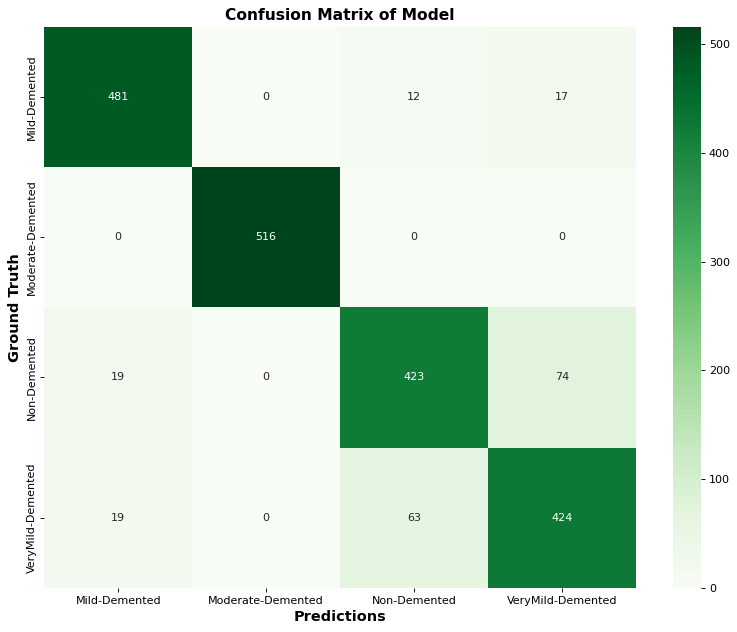

In [19]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

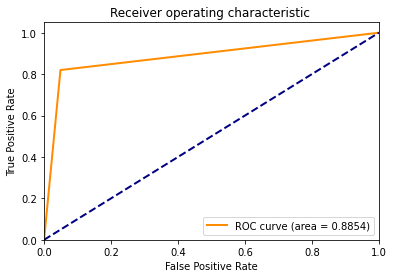

In [20]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

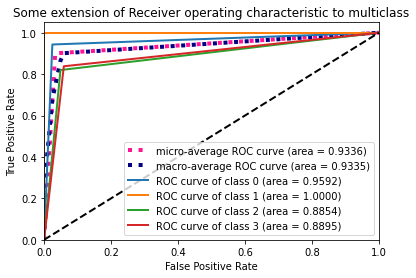

In [21]:
n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

### <font color=orange> Saving Model for Future Use </font>

In [22]:
#    To save the model in the current directory
model.save(".\\model.h5")